# Connected component labeling
Here we compare performance connected component labeling algorithms implemented in [cupy](https://cupy.dev), [scikit image](https://scikit-image.org) and clEsperanto.

Note: benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. Use this notebook to adapt it to your use-case scenario and benchmark on your target hardware. If you have different scenarios or use-cases, you are very welcome to submit your notebook as pull-request!

In [1]:
import pyclesperanto_prototype as cle
from skimage import filters
import time

# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX')

<GeForce RTX 2080 Ti on Platform: NVIDIA CUDA (1 refs)>

In [2]:
# test data
import numpy as np

sigma = 10
pointlist = np.random.random([3, 200]) * 400

image = cle.create((400, 400, 400))
cle.set(image, 0)

cle.pointlist_to_labelled_spots(pointlist, image)

blobs = cle.maximum_sphere(image, radius_x=10, radius_y=10, radius_z=10)

binary_blobs = cle.greater_constant(blobs, constant=0)

binary_image = cle.pull(binary_blobs)

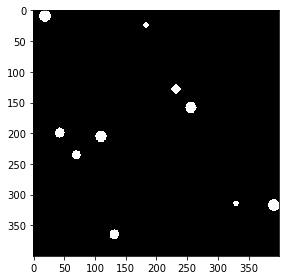

In [3]:

from skimage.io import imshow
imshow(binary_image[50])

# scikit-image

skimage label duration: 0.5534896850585938
skimage label duration: 0.5589733123779297
skimage label duration: 0.5973742008209229
skimage label duration: 0.5525546073913574
skimage label duration: 0.5963160991668701
skimage label duration: 0.6306900978088379
skimage label duration: 0.5712888240814209
skimage label duration: 0.6745197772979736
skimage label duration: 0.5723729133605957
skimage label duration: 0.6139242649078369


C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


188

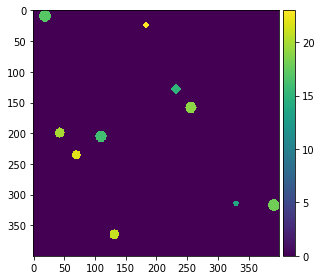

In [4]:
# label with scikit-image
from skimage.measure import label

result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = label(binary_image)
    print("skimage label duration: " + str(time.time() - start_time))
    
imshow(result_image[50])
np.max(result_image)

# clEsperanto

clEsperanto label duration: 0.15620994567871094
clEsperanto label duration: 0.12492918968200684
clEsperanto label duration: 0.11988615989685059
clEsperanto label duration: 0.10935020446777344
clEsperanto label duration: 0.1263105869293213
clEsperanto label duration: 0.11313104629516602
clEsperanto label duration: 0.1284477710723877
clEsperanto label duration: 0.10721683502197266
clEsperanto label duration: 0.12795710563659668
clEsperanto label duration: 0.09817790985107422


C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


188.0

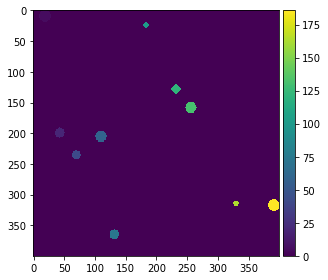

In [5]:
ocl_binary_image = cle.push(binary_image)

result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.connected_components_labeling_box(ocl_binary_image, result_image)
    print("clEsperanto label duration: " + str(time.time() - start_time))

result = cle.pull(result_image)
imshow(result[50])
np.max(result)

# cupy

cupy label duration: 0.2186901569366455
cupy label duration: 0.0
cupy label duration: 0.01562047004699707
cupy label duration: 0.0
cupy label duration: 0.015591859817504883
cupy label duration: 0.0
cupy label duration: 0.0
cupy label duration: 0.01565861701965332
cupy label duration: 0.0
cupy label duration: 0.015621662139892578


C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


190.0

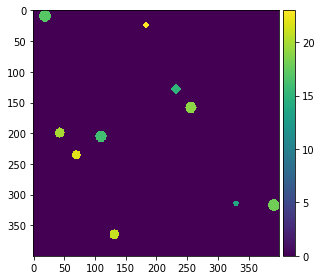

In [6]:
import cupy
from cupyx.scipy import ndimage as ndi

cuda_binary_image = cupy.asarray(binary_image)

cuda_labeled = cupy.ndarray(image.shape)
for i in range(0, 10):
    start_time = time.time()
    ndi.label(cuda_binary_image, output=cuda_labeled)
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    print("cupy label duration: " + str(time.time() - start_time))
          
result = cupy.asnumpy(cuda_labeled)
imshow(result[50])
np.max(result)